<a href="https://colab.research.google.com/github/chernandezrojas1991/predicciones-de-ventas-de-alimentos/blob/main/predicciones_de_ventas_de_alimentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(display='diagram')
pd.options.display.float_format = '{:.2f}'.format

In [4]:
filename = "/content/drive/MyDrive/Coding Dojo/Unidad 1/Semana 2/sales_predictions_2023.csv"
sales_prediction_df = pd.read_csv(filename)
sales_prediction_df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,NaN,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


Convert to lowercase column names

In [5]:
sales_prediction_df.columns = sales_prediction_df.columns.str.lower()
sales_prediction_df.columns

Index(['item_identifier', 'item_weight', 'item_fat_content', 'item_visibility',
       'item_type', 'item_mrp', 'outlet_identifier',
       'outlet_establishment_year', 'outlet_size', 'outlet_location_type',
       'outlet_type', 'item_outlet_sales'],
      dtype='object')

1) ¿Cuántas filas y columnas hay?

In [6]:
sales_prediction_df.shape

(8523, 12)

El dataframe tiene 8523 filas (observaciones) y 12 columnas.

2) ¿Cuáles son los tipos de datos de cada variable?

In [8]:
sales_prediction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                7060 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   int64  
 8   outlet_size                6113 non-null   object 
 9   outlet_location_type       8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


El dataframe está compuesto de columnas de distinto tipo, las cuales se detallan a continuación:


*   object: item_identifier, item_fat_content, item_type, outlet_identifier, outlet_size, outlet_location_type, outlet_type.
*   float64: item_weight, item_visibility, item_mrp, item_outlet_sales.
*   int64: outlet_establishment_year.



3) ¿Hay duplicados? Si es el caso, elimínelos.

In [9]:
# Count the duplicates
sales_prediction_df.duplicated().sum()

0

No hay datos duplicados. Por lo tanto, no se hará código para eliminar duplicados.

4) Identifique los valores faltantes.

In [10]:
sales_prediction_df.isna().sum()

item_identifier                 0
item_weight                  1463
item_fat_content                0
item_visibility                 0
item_type                       0
item_mrp                        0
outlet_identifier               0
outlet_establishment_year       0
outlet_size                  2410
outlet_location_type            0
outlet_type                     0
item_outlet_sales               0
dtype: int64

La columna item_weight tiene 1463 datos faltantes, mientras que outlet_size tiene 2410.

**Importante:** Dado que los datos faltantes se les imputará la media de éstos, se procede primero a la selección de características X y de variable objetivo (target) y.

Selección de características: (X) e objetivo (y) y uso de la función train_test_split().

In [14]:
X = sales_prediction_df.drop('item_outlet_sales', axis=1)
y = sales_prediction_df['item_outlet_sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Creación de pipeline de preprocesamiento para preparar el conjunto de datos para aprendizaje automático.

Identificar columnas de tipo numérico y categóricas.

In [15]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

Creación de imputers: La función *freq_imputer* para imputar el valor más frecuente (moda) a aquellas celdas consideradas 'missing values'. Uso de la función *mean_imputer* para imputar la media de los datos.

In [16]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

Creación del pipeline con *freq_imputer* usando codificación One-Hot para crear nuevas columnas cuyos nombres serán las categorias registradas en la columna *outlet_size* (tamaño de la tienda): Low, Medium y High.

In [17]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

Creación del pipeline con *mean_imputer* usando StandardScaler para escalar los valores de la columna *item_weight* (peso del producto).

In [18]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

Creación de tuplas para Column Transformer (transformador de columnas) para modificar el conjunto de datos y proceder a crear las columnas nuevas para el pre procesamiento de datos.

In [19]:
# Tuplas para Column Transformer
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78c3255ea740>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78c3255e9ff0>)])

Es claro ver que se tiene un transformador con dos pipelines dentro. El primer pipeline (también llamado "pipeline-1") contiene el imputador para datos escalares (numéricos) y el segundo pipeline (llamado "pipeline-2) contiene el codificador One-Hot antes descrito.

Se usa el método fit() para ajustar los transformadores dentro.

In [20]:
preprocessor.fit(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78c3255ea740>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x78c3255e9ff0>)])

Se procede a transformar los datos propuestos.

In [21]:
# transform train and test
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Por último, se verifica si aún quedan *missing values*. Para ello, se hace lo siguiente:

In [22]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1595)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])

Es claro visualizar que el conjunto de datos de entrenamiento no tiene datos faltantes (missing values) como tampoco el conjunto de datos de testing.

El preprocesamiento fue exitoso.

# 5) Tratar los valores faltantes y cómo hacerlo. (A criterio del cientista de datos y justificación de la elección tomada).

Dado que el porcentaje de datos faltantes excede el 2% del total de datos, no es recomendable eliminar las observaciones con dichos datos faltantes. Tampoco es buena opción eliminar las columnas, ya que item_weight y outlet_size están relacionadas directamente con lo que podría ser la predicción de ventas de alimentos, por lo cual se descarta esta posibilidad de tratamiento de valores faltantes.

La opción más apropiada para rellenar item_weight, a criterio del científico de datos, es rellenar estos datos faltantes con el promedio de valores de la columna en cuestión. Esta decisión se apoya en que el valor promedio se acerca al valor correcto. Y para la columna outlet_size se determina que, al ser una variable categórica (discreta), es rellenar con una nueva categoría llamada 'Missing'.

In [23]:
average_item_weight = sales_prediction_df['item_weight'].median()
sales_prediction_df['item_weight'].fillna(average_item_weight, inplace=True)
sales_prediction_df['outlet_size'].fillna('Missing', inplace=True)

6) Confirme que no hay valores faltantes después de tratarlos.

In [24]:
sales_prediction_df.isna().sum()

item_identifier              0
item_weight                  0
item_fat_content             0
item_visibility              0
item_type                    0
item_mrp                     0
outlet_identifier            0
outlet_establishment_year    0
outlet_size                  0
outlet_location_type         0
outlet_type                  0
item_outlet_sales            0
dtype: int64

7) Encuentre y arregle cualquier categoría inconsistente en los datos (ejemplo: arreglar los datos gato, Gato y Gatos de manera que sean consistentes)

In [25]:
sales_prediction_df.head()

,item_identifier,item_weight,item_fat_content,item_visibility,item_type,item_mrp,outlet_identifier,outlet_establishment_year,outlet_size,outlet_location_type,outlet_type,item_outlet_sales
0,FDA15,9.30,Low Fat,0.02,Dairy,249.81,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.14
1,DRC01,5.92,Regular,0.02,Soft Drinks,48.27,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.42
2,FDN15,17.50,Low Fat,0.02,Meat,141.62,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.27
3,FDX07,19.20,Regular,0.00,Fruits and Vegetables,182.09,OUT010,1998,Missing,Tier 3,Grocery Store,732.38
4,NCD19,8.93,Low Fat,0.00,Household,53.86,OUT013,1987,High,Tier 3,Supermarket Type1,994.71


Fix names to get only 'Low Fat' and 'Regular' to item_fat_content column.

In [26]:
sales_prediction_df['item_fat_content'] = sales_prediction_df['item_fat_content'].replace('LF', 'Low Fat')
sales_prediction_df['item_fat_content'] = sales_prediction_df['item_fat_content'].replace('reg', 'Regular')
sales_prediction_df['item_fat_content'] = sales_prediction_df['item_fat_content'].replace('low fat', 'Low Fat')
sales_prediction_df['item_fat_content'].value_counts()

item_fat_content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

8) Para cualquier columna numérica, obtenga las estadísticas resumidas de cada una (mínimo, máximo y media)

In [27]:
sales_prediction_df['item_weight'].describe()

count   8523.00
mean      12.81
std        4.23
min        4.55
25%        9.31
50%       12.60
75%       16.00
max       21.35
Name: item_weight, dtype: float64

Se elige la columna 'item weight'. Usar la función describe() permite obtener estadísticas básicas de la columna en cuestión. Se visualiza el valor mínimo 4.55, valor máximo 21.35 y la media 12.81. Es claro ver que da a conocer otras estadísticas resumidas que pueden ser muy valiosas a la hora de tratar con ellas.

# Análisis Estadístico

Para tener mayor entendimiento del contexto de este proyecto, se lista a continuación las descripciones de las características de este conjunto de datos.


*   **item_weight**: Peso del producto. Para efectos de mayor entendimiento, se asumirá que los pesos de productos (item_weight) está medido en kilogramos (kg).
*   **item_visibility**: Porcentaje de área total de exposición de todos los productos para una tienda asignada al producto concreto.
*   **item_mrp**: Precio máximo de venta al público (precio de catálogo) del producto.
*   **outlet_stablishment_year**: Año en que se estableció la tienda.
*   **item_outlet_sales**: Ventas del producto en una tienda particular. Esta la variable objetivo a predecir.



1) Histograma para ver las distribuciones de las diversas características en el conjunto de datos.

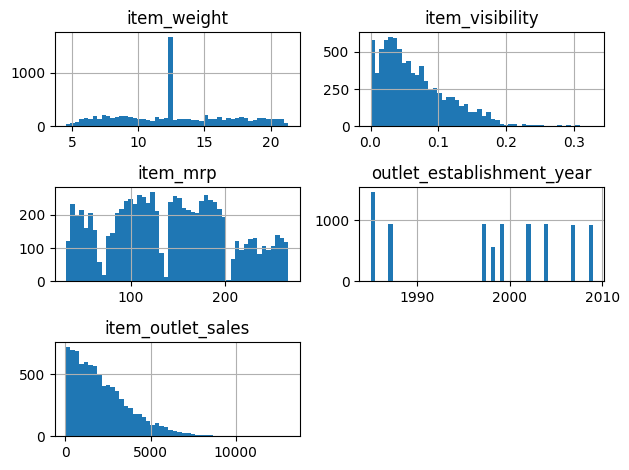

In [28]:
#Use bins 50 to have more bars
sales_prediction_df.hist(bins = 50)
plt.xticks(rotation = 45)
plt.ticklabel_format(useOffset=False, style='plain')
plt.tight_layout()
plt.show()

Se analizará los histogramas en orden:
1. **item_weight:** El peso de los items (o productos) va desde 5 a 20, según su unidad de medida. En el histograma es claro observar que existe una frecuencia que sobrepasa las 1000 unidades para aquellos productos que en promedio están entre los 10 y 15 kilogramos. El resto de los productos no presenta grandes variaciones y se mantiene constante con una frecuencia aproximada de 200 y 300.

2. **item_visibility**: El porcentaje de exposición del producto presenta un pick entre el 0.0 y el 5% con una frencuencia de aparición de 1000. Esto indica que para ciertos productos, el área de visibilidad o exposición en tienda del mismo ocupa casi un 5%, mientras que otros productos que tienen una visibilidad mayor casi al 10% tienen una frecuencia menor y va descendiendo a medida que crece el porcentaje de visibilidad. En otras palabras, sin efectuar ningún cálculo previo usando la función corr(), se puede inferir que existe una correlación negativa, es decir, a menor visibilidad de un producto es mayor la frecuencia (cantidad de veces que se dió lugar a la visibilidad de éste).

3. **item_mrp**: El precio máximo de los productos es variable para este conjunto de datos. Pero sí se puede observar que los productos cuyo valor está dentro del rango 50 a 200 (según sea su moneda). Además, cuyos valores de 200 en adelante se mantienen constantes con una frecuencia de registro (o aparición) de 200 o cercano a 200.

4. **outlet_establishment_year**: Hubo un pick de instalación de tiendas en los años 90', mientras que hubo una baja muy significativa de instalaciones entre fines de los 90' y comienzos de los 2000'. Luego, hubo un alza significativa de instalación de tiendas durante los años 2000' a 2010'.

5. **item_outlet_sales**: Se infiere que hubo un pick en la venta de productos superando las 500 unidades por tienda, pero esta cifra va disminuyendo a medida que se iban instalaron más tiendas que vendían el mismo producto, la venta por tienda disminuyó.

2) Boxplot para ver resúmenes estadísticos de diversas características del conjunto de datos.
Mapa de calor de correlación entre las características.

**Boxplot of Item Weights with Mean Values**

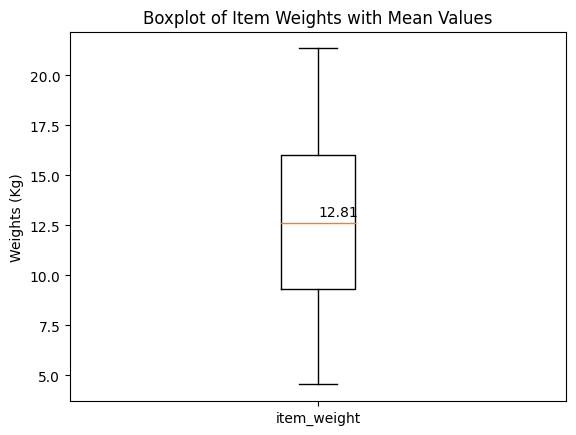

In [29]:
item_weight_mean = sales_prediction_df['item_weight'].mean()
plt.boxplot(sales_prediction_df['item_weight'])
plt.text(1, item_weight_mean, f'{item_weight_mean:.2f}', va='bottom')
plt.xticks([1], ['item_weight'])
plt.ylabel('Weights (Kg)')
plt.title('Boxplot of Item Weights with Mean Values')
plt.show()

Es claro ver que existe un valor promedio para los pesos de productos de 12.81 kg (marcado con una línea horizontal color naranjo). Por otro lado, la distribución de los datos se ve equilibrada. Los valores más cercanos a la media son aquellos ubicados en los rangos [9.5, 16.5] kg aproximadamente. No existen outliers para esta característica.

El peso de los productos podría dar indicadores de cuánto una persona podría cargar al momento de retiro de la tienda. No sería lo mismo cargar 5 kg de tomates versus 25 kg de un saco de harina. O bien, no ofrecer cantidades o volúmenes de productos en versión más pequeña podría interferir en las ganancias de una tienda. Por ejemplo, si una tienda ofrece jugos embotellados de 4 litros y una persona que se traslada todos los días caminando desde su casa al trabajo, sólo desea obtener un jugo embotellado de 450 cc (se puede transportar fácilmente en su bolso), no podría o le sería muy difícil transportar una botella de 4 litros.

**Boxplot of Visibility Percetage with Mean Values**

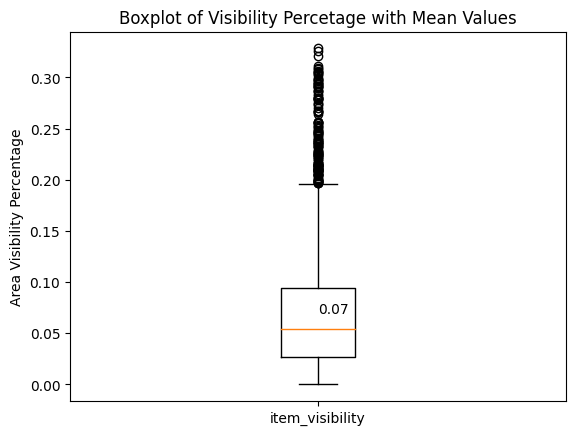

In [30]:
item_visibility_mean = sales_prediction_df['item_visibility'].mean()
plt.boxplot(sales_prediction_df['item_visibility'])
plt.text(1, item_visibility_mean, f'{item_visibility_mean:.2f}', va='bottom')
plt.xticks([1], ['item_visibility'])
plt.ylabel('Area Visibility Percentage')
plt.title('Boxplot of Visibility Percetage with Mean Values')
plt.show()

El valor promedio es de 0.07, vale decir, un 7% de área de visibilidad en promedio de un producto, dentro de una tienda en el que se exhibe para su venta. Los datos cercanos a la media rondan entre [0.3, 0.10]. En otras palabras, un producto, en este conjunto de datos, le corresponde entre un 3% y un 10% de área de visibilidad o exposición dentro de la tienda.

Por otro lado, existen muchos datos considerados outliers que superan el 20% de área de visibilidad. Estos porcentajes es importante estudiarlos, dado que con ellos y otras estadísticas se podría determinar qué productos necesitan mayor área de visibilidad que otros. Si se describen ejemplos cotidianos, un supermercado ofrece una mayor área de visibilidad del sector de panadería cercano a las cajas versus una menor área de visibilidad de un sector de productos más específicos y no tan cotidianos como compra de artículos para autos.

**Boxplot of Maximum Sale value (item_mrp) with Mean Values**

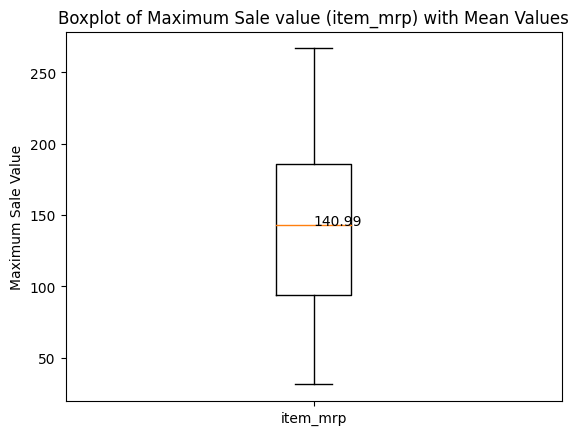

In [ ]:
item_mrp_mean = sales_prediction_df['item_mrp'].mean()
plt.boxplot(sales_prediction_df['item_mrp'])
plt.text(1, item_mrp_mean, f'{item_mrp_mean:.2f}', va='bottom')
plt.xticks([1], ['item_mrp'])
plt.ylabel('Maximum Sale Value')
plt.title('Boxplot of Maximum Sale value (item_mrp) with Mean Values')
plt.show()

El valor máximo de venta, en promedio, para los productos registrados en este conjunto de datos es de $140.99 (aplicar moneda según sea el país). La caja del diagrama tiene una distribución balanceada de datos, en la cual existe una cantidad similar de datos que comprenden Q1 y Q3 (cuartil desde el uno al tres).

Definir valores máximos de productos ayuda a conocer qué tanto las personas estarían dispuestas a pagar por él, descubrir por qué las ventas se incrementan para una tienda y para cuáles no, si la calidad del producto es óptima, su fecha de caducidad es más lejana respecto al momento de compra, etc.

**Boxplot of Outlet Establishment Year with Mean Values**

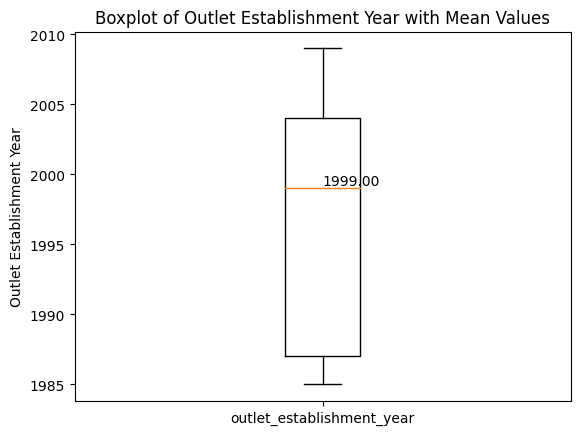

In [31]:
outlet_establishment_year_mean = sales_prediction_df['outlet_establishment_year'].median()
plt.boxplot(sales_prediction_df['outlet_establishment_year'])
plt.text(1, outlet_establishment_year_mean, f'{outlet_establishment_year_mean:.2f}', va='bottom')
plt.xticks([1], ['outlet_establishment_year'])
plt.ylabel('Outlet Establishment Year')
plt.title('Boxplot of Outlet Establishment Year with Mean Values')
plt.show()

El año, según la distribución de los datos, ubicado al medio de todo el conjunto fue el año 1999. En aquel año, la mayoría de las tiendas se instaló y abrió para disponer a vender productos. Cabe destacar que existe una gran cantidad de registros de tiendas abiertas previo al año 1999 y, en menor medida, tiendas abiertas cuyos años son superiores a 1999.

Se desconoce de momento la verdadera razón de por qué hubo apertura de tiendas en estos rangos de años, pero se podría inferir por la aparición de nuevos alimentos o nuevas categorías de ellos o cuyo envasado es más cómodo en cuanto a tamaño, cantidad, materiales de producción, origen animal o vegetal, reducción de uso de plásticos, reducción de huella de carbono, entre otros. Estos aspectos se podrían estudiar en trabajos futuros.

**Boxplot of Item Outlet Sales with Mean Values**

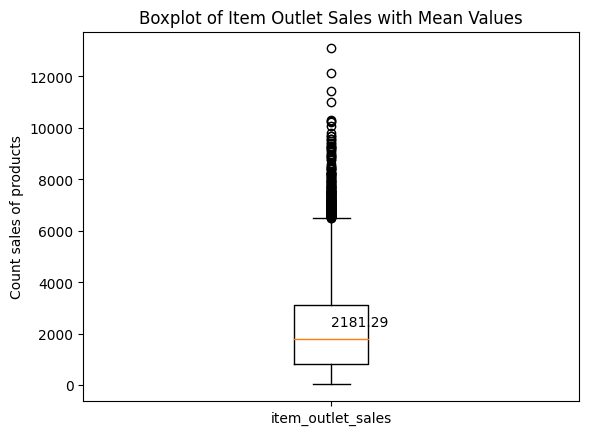

In [32]:
item_outlet_sales_mean = sales_prediction_df['item_outlet_sales'].mean()
plt.boxplot(sales_prediction_df['item_outlet_sales'])
plt.text(1, item_outlet_sales_mean, f'{item_outlet_sales_mean:.2f}', va='bottom')
plt.xticks([1], ['item_outlet_sales'])
plt.ylabel('Count sales of products')
plt.title('Boxplot of Item Outlet Sales with Mean Values')
plt.show()

Las ventas, en promedio, de un producto particular tuvo una cifra de 2181 veces, valga la redundancia, que fue vendido. Además, es claro ver que las ventas de los productos no superan las 4000 ocasiones en que las ventas fueron efectivas, como también es claro ver que no existen productos que no fueron vendidos nunca o bien, su frecuencia de venta no efectiva es casi no considerable.

Sin embargo, existe un amplio registro de productos vendidos que superan las 6000 veces que fueron comprados efectivamente, alcanzando no más de 10.000 veces. Y un registro no tan fuerte en más allá de las 12.000 veces de venta efectiva. Esto podría ayudar a qué productos las tiendas debiesen enfocar sus esfuerzos en vender, publicitar, descontar en caso de ofertas para incrementar sus ventas y poder predecir de forma más precisa sus ganancias diarias, mensuales o anuales; depende del horizonte de evaluación de cada tienda.

# Análisis de datos explicativos

En esta sección, se visualizan gráficos para comprender mejor las tendencias de los datos y ayudar a la predicción de ventas de alimentos para las tiendas.

Se determinó que las variables a estudiar son:


*   item_Outlet_Sales
*   item_visibility
*   item_Fat_Content
*   outlet_size
*   outlet_type

El primer gráfico se conforma, por un lado, en el eje X por contenido de grasa del ítem (item_Fat_Content) y, por otro lado, en el eje Y por la visibilidad del ítem (item_Visibility).

Se decide hacer este gráfico para analizar y estudiar qué tienen que ver los alimentos cuyo contenido de grasa están más expuestos o tienen mayor visibilidad en vitrinas para llamar la atención del cliente. Estos alimentos suelen ser calóricos, altos en azúcares y suelen ser comprados para el consumo inmediato.



# Análisis de Contenido de grasa vs Visibilidad de productos

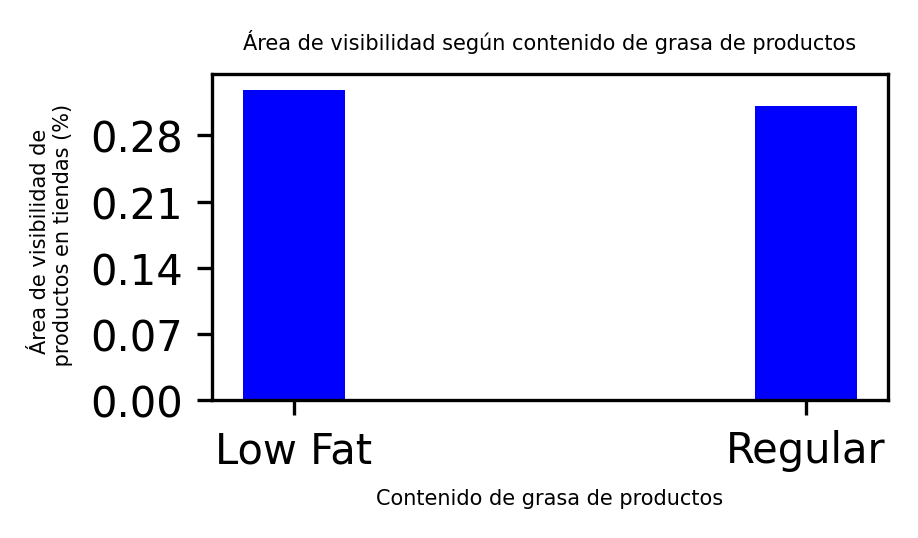

In [33]:
#Item visiblity
#Item_fat_content
multivariate_visualizations_figure = plt.figure(dpi = 300)
multivariate_ax1 = multivariate_visualizations_figure.add_subplot(3,2,1)

#Axis X
item_fat_content_array = np.array(sales_prediction_df['item_fat_content'])
#Axis Y
item_visibility_array = np.array(sales_prediction_df['item_visibility'])
yRange = np.arange(sales_prediction_df['item_visibility'].min(), sales_prediction_df['item_visibility'].max(), 0.07)

multivariate_ax1.bar(item_fat_content_array, item_visibility_array, 0.2, color='blue')
plt.title("Área de visibilidad según contenido de grasa de productos", fontsize=5)
plt.xlabel("Contenido de grasa de productos", fontsize=5)
plt.ylabel("Área de visibilidad de \n productos en tiendas (%)", fontsize=5)
plt.yticks(yRange)
plt.show()

Es claro observar que el porcentaje de visibilidad de los productos registrados en el dataframe y estudiados en el presente documento, indican que no existen grandes diferencias en cuanto a su exposición. Por lo tanto, no se podría predecir mayores o menores ventas de éstos. Se estudiará usando otras variables para obtener información que ayude a predecir ventas de alimentos.

# Análisis de Visibilidad de productos de mayores ganancias de acuerdo a su tipo y ventas

Para realizar un análisis de visibilidad de productos en tiendas de acuerdo al tipo de producto y las ventas que éste registró, es necesario saber cuáles son aquellos tipos de productos que registran mayores ganancias. Para ello, se escribe el siguiente código para obtener dicha información.

In [34]:
sales_total_by_type = sales_prediction_df.groupby('item_type')['item_outlet_sales'].sum()
sales_total_by_type.sort_values(ascending=False).head(2)

item_type
Fruits and Vegetables   2820059.82
Snack Foods             2732786.09
Name: item_outlet_sales, dtype: float64

Se obtuvo que aquellos productos pertenecientes a las frutas y vegetales (Fruits And Vegetables) y snacks (Snack Foods) son aquellos alimentos de los cuales más se obtienen más ganancias para las tiendas.

Para fines de este análisis, se determinó que se va a analizar sólo dos del conjunto de alimentos. Estos fueron ordenados de forma descendente y los primeros dos se van a utilizar para generar un gráfico de dispersión para estudiar la tendencia que tienen al comparar su grado de exposición o área de visibilidad en tiendas junto con las ganancias obtenidas.

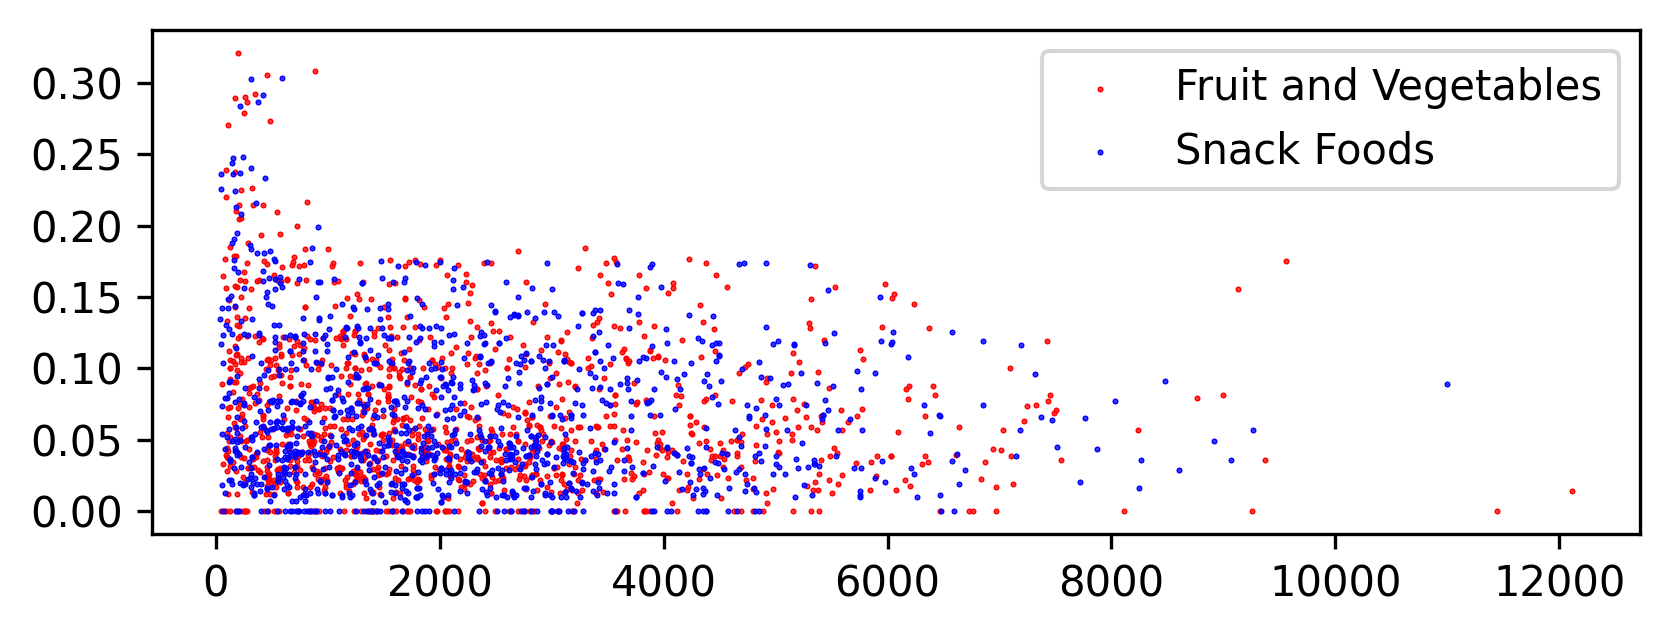

In [36]:
multivariate_visualizations_figure = plt.figure(dpi = 300)
multivariate_ax1 = multivariate_visualizations_figure.add_subplot(2,1,1)

#Filter by Fruits and Vegetables / Snack Foods
first_foods_filter = sales_prediction_df["item_type"].eq("Fruits and Vegetables") | sales_prediction_df["item_type"].eq("Snack Foods")
first_two_foods_df = sales_prediction_df.loc[first_foods_filter,:]

#Adjustment axis Y
yRange = np.arange(first_two_foods_df['item_visibility'].min(), first_two_foods_df['item_visibility'].max(), 0.05)
plt.yticks(yRange)

#Get outlet sales according to item types with more profits
x_axis_fruit_sales =  sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Fruits and Vegetables"), "item_outlet_sales"]
x_axis_snack_sales =  sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Snack Foods"), "item_outlet_sales"]
y_axis_fruit_visibility = sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Fruits and Vegetables"), "item_visibility"]
y_axis_snack_visibility = sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Snack Foods"), "item_visibility"]

sales = {'Fruit and Vegetables': np.array(x_axis_fruit_sales), 'Snack Foods': np.array(x_axis_snack_sales)}
visibility = {'Fruit and Vegetables': np.array(y_axis_fruit_visibility), 'Snack Foods': np.array(y_axis_snack_visibility)}

plt.scatter(sales['Fruit and Vegetables'], visibility['Fruit and Vegetables'], c='red', s=0.2, label='Fruit and Vegetables')
plt.scatter(sales['Snack Foods'], visibility['Snack Foods'], c='blue', s=0.2, label='Snack Foods')

multivariate_ax1.legend(loc = 'upper right')
plt.show()

Se observa que los datos están aglutinados en mayor medida con un porcentaje de visibilidad entre 0% y 5% y las ganancias fluctúan entre los 1000 y 3000 dólares aproximadamente.

Además, existe en menor medida un conjunto de productos que no obtuvo mayores ganancias, sin embargo, su área de visibilidad en las tiendas se encuentra entre el 15% y 30%. Se puede inferir que estos productos no requieren de mayor área visibilidad para obtener mejores ganancias.

Y, finalmente, se visualiza un conjunto de datos en el extremo derecho del gráfico de dispersión los cuales están más dispersos aún, cuya área de visibilidad en tiendas fluctúa entre 5% y 15% con ganancias más elevadas, cercanas a 5000 y que alcanzan los 8000 dólares.

En conclusión, los productos relativos a frutas y verduras y snacks son los que lograron mayores ganancias para las tiendas y que no tienen necesidad de un área extensa de visibilidad para sus clientes. Esto puede ser un indicador que al ocupar mayor área de visibilidad, le quita área a otros productos que sí necesitan mayor área y, por esta razón, puede ser que la tienda no genere mayores ganancias.

Se estima que con un área entre el 5% y 15% de las tiendas, se pueden alcanzar muchas ganancias sin dejar de lado a otros productos que podrían requerir más área de exhibición.

# Análisis de Visibilidad de productos de menores ganancias de acuerdo a su tipo y ventas

Este análisis se pretende contestar las siguientes preguntas:


*   ¿Qué productos tienen menor área de visibilidad?
*   ¿Se venden menos por tener menor área de visibilidad?
*   ¿Podrían existir otros factores no considerados en el conjunto de datos que incida directamente en las ventas?



Al igual que el análisis anterior, se agrupan los tipos de alimentos y se obtienen sus ventas totales, pero a diferencia del anterior, se extrae aquellos con menores ventas.

In [37]:
sales_total_by_type = sales_prediction_df.groupby('item_type')['item_outlet_sales'].sum()
sales_total_by_type.sort_values(ascending=True).head(2)

item_type
Seafood     148868.22
Breakfast   232298.95
Name: item_outlet_sales, dtype: float64

Los productos con menores ventas son: Productos marinos (Seafood) y desayunos (breakfast).

Para fines de este análisis, se crea un gráfico de dispersión para observar el comportamiento de los datos y ser capaz de responder aquellas preguntas definidas anteriormente.


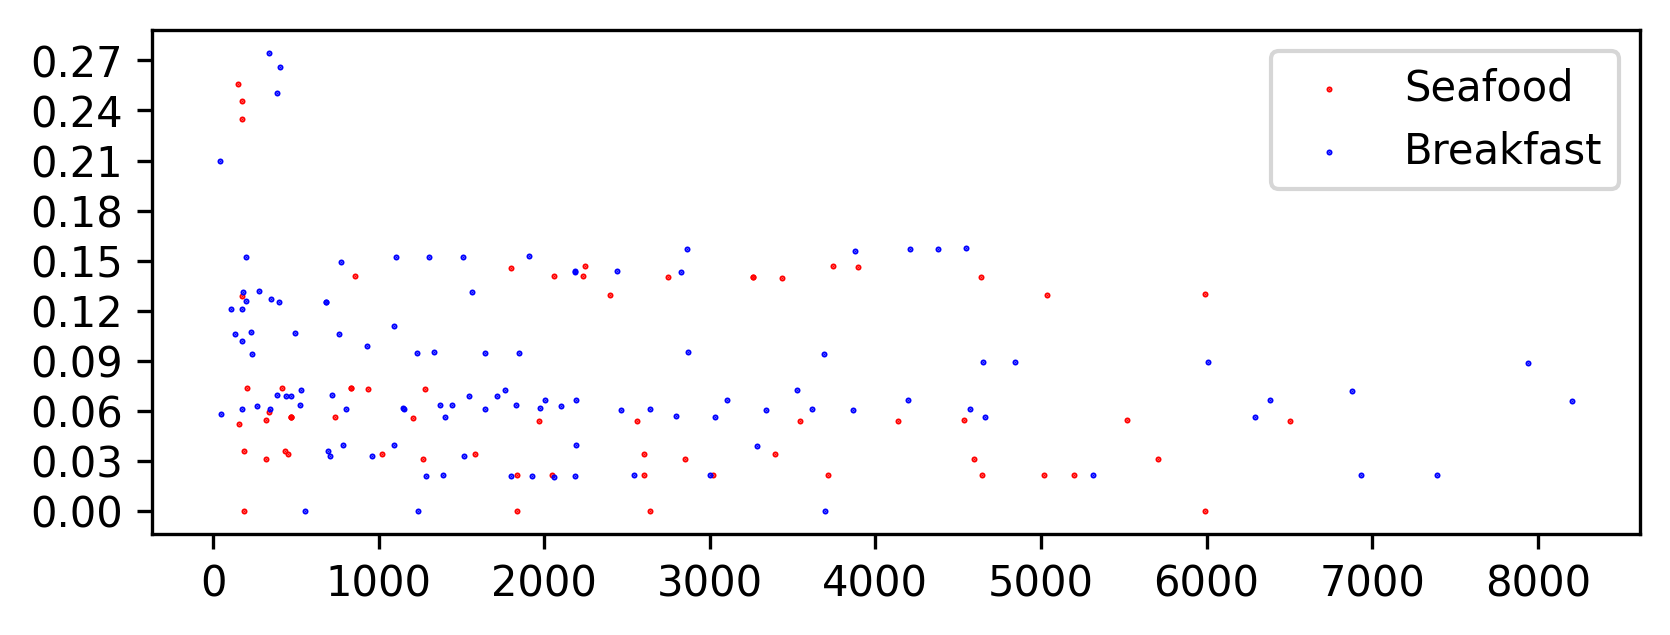

In [38]:
multivariate_visualizations_figure = plt.figure(dpi = 300)
multivariate_ax1 = multivariate_visualizations_figure.add_subplot(2,1,1)

#Filter by Seafood / Breakfast
last_foods_filter = sales_prediction_df["item_type"].eq("Seafood") | sales_prediction_df["item_type"].eq("Breakfast")
last_two_foods_df = sales_prediction_df.loc[last_foods_filter,:]

#Adjustment axis Y
yRange = np.arange(last_two_foods_df['item_visibility'].min(), last_two_foods_df['item_visibility'].max(), 0.03)
plt.yticks(yRange)

#Get outlet sales according to item types with less profits
x_axis_seafood_sales =  sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Seafood"), "item_outlet_sales"]
x_axis_breakfast_sales =  sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Breakfast"), "item_outlet_sales"]
y_axis_seafood_visibility = sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Seafood"), "item_visibility"]
y_axis_breakfast_visibility = sales_prediction_df.loc[sales_prediction_df["item_type"].eq("Breakfast"), "item_visibility"]

sales = {'Seafood': np.array(x_axis_seafood_sales), 'Breakfast': np.array(x_axis_breakfast_sales)}
visibility = {'Seafood': np.array(y_axis_seafood_visibility), 'Breakfast': np.array(y_axis_breakfast_visibility)}

plt.scatter(sales['Seafood'], visibility['Seafood'], c='red', s=0.2, label='Seafood')
plt.scatter(sales['Breakfast'], visibility['Breakfast'], c='blue', s=0.2, label='Breakfast')

multivariate_ax1.legend(loc = 'upper right')
plt.show()

Los datos están muy dispersos, pero se puede hallar ciertos patrones en ellos. Un patrón reconocible para aquellos productos relativos a desayunos (Breakfast) siguen una tendencia casi lineal cuando el área de visibilidad está muy cerca del 6% y, por otro lado, muy cerca de un 15% de área de visibilidad. Sus ventas alcanzan cifras que van desde los 500 a los 4000 para ambos conjuntos de porcentajes. Este grupo que sigue dicho patrón, obtuvo ventas considerables.

También se observa que la cantidad de datos graficados es considerablemente menor que el gráfico de dispersión anterior. Esto podría indicar que corresponde a tipos de alimentos menos vendidos por las tiendas o que carecen de una cantidad considerable de registros en el dataframe.

Existe un pequeño grupo, minúsculo, que su porcentaje del área de visibilidad de productos marinos y de desayuno es elevado, entre el 24% y 27%. Sin embargo, sus ventas son bajísimas.

En cuanto a las preguntas propuestas al inicio, se concluye lo siguiente:

1) Los productos con menor área de visibilidad son relativos. Puede ser por distintos factores: tamaño de la tienda, costo de los productos, área de visibilidad extensa de otros productos.

2) Es evidente que no es necesario tener mayor área de visibilidad para vender más productos relativos a un tipo.

3) Podrían existir otros factores no considerados que incidan en las ventas. Se podría considerar la antigüedad de la tienda. El conjunto de datos menciona una variable que apunta a la fecha en que se instaló una tienda. Se puede inferir que la clientela conoce los productos que vende una tienda determinada y sus ventas pueden mantenerse, sin necesidad de incrementar visibilidad. Esto es solo una inferencia. Se deben hacer cálculos más exhaustivos para tener argumentos sólidos que apoyen esta hipótesis.

# Matriz de Confusión (WIP)

